# Numerical differentiation of unequally sampled data using Machine Learning - 2nd derivative
- _Pascal Tribel - Machine Learning Group_
- _December 2024_
## Question
How does the error evolve when the algorithms are used recursively to compute the $n^{th}$ derivative ?
If the algorithm is a good approximation of the derivative operator, composing it with itself should not see an increasing error.
## Code
### Libraries import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import neuralop
from neuralop.models import FNO1d
import matplotlib.pyplot as plt
import seaborn as sns
import symengine as se
import pandas as pd
from tqdm.auto import tqdm
from copy import deepcopy
from joblib import Parallel, delayed
import scipy

### Functions Definition
#### Error measurement

In [2]:
def error(x, y):
    return np.mean(np.abs(x-y))

### Numerical approaches

In [3]:
def diff_central(f_x, x, y):
    x = np.asarray(x)
    f_x = np.asarray(f_x)
    y = np.asarray(y)
    f_prime_y = np.zeros_like(y, dtype=float)
    for j, y_j in enumerate(y):
        for i, y_i in enumerate(y_j):
            x_right_idx = min(np.searchsorted(x[j], y_i, side='left'), x[j].shape[0] - 1)
            x_left_idx = x_right_idx - 1
            x_0, x_1 = x[j, x_left_idx], x[j, x_right_idx]
            f_0, f_1 = f_x[j, x_left_idx], f_x[j, x_right_idx]
            
            if x_1 != x_0:
                f_prime_y[j, i] = (f_1 - f_0) / (x_1 - x_0)
            else:
                raise ValueError(f"Duplicate x values found at indices {x_left_idx} and {x_right_idx}.")
        break
    return f_prime_y

def n_th_diff_central(f_x, x, y, n):
    f_prime_y = []
    for i in range(f_x.shape[0]):
        f_prime_y_i = diff_central(f_x[i:i+1], x[i:i+1], y[i:i+1])
        for _ in range(int(n[i].item())-1):
            f_prime_y_i = diff_central(f_prime_y_i, x[i:i+1], y[i:i+1])
        f_prime_y.append(f_prime_y_i)
    return np.array(f_prime_y)

def diff_interpolate(y, x, q):
    if len(q.shape)==1:
        return scipy.interpolate.UnivariateSpline(np.array(x), np.array(y), k=5).derivative()(np.array(q))[:-1]
    else:
        return np.array([scipy.interpolate.UnivariateSpline(np.array(x[i]), np.array(y[i]), k=5).derivative()(np.array(q[i]))[:-1] for i in range(q.shape[0])])

def n_th_diff_interpolate(y, x, q, n):
    f_prime_y = []
    for i in range(y.shape[0]):
        f_prime_y_i = diff_interpolate(y[i:i+1], x[i:i+1], q[i:i+1])
        for z in range(1, int(n[i].item())):
            f_prime_y_i = diff_interpolate(f_prime_y_i, x[i:i+1, :-z], q[i:i+1, :-z])
        f_prime_y.append(f_prime_y_i)
    return f_prime_y

### Random polynom generation

In [4]:
def random_polynom(x):
    degree = np.random.randint(2, 3)
    expression = 0.01*(float(np.random.random() - 0.5)) * x**degree
    degree -= 1
    while degree >= 0:
        expression += 0.01*(float(np.random.random() - 0.5)) * x**degree
        degree -= 1
    return expression

### Random assembling of the base functions

In [5]:
def random_transform(f, x):
    return f((10*float(np.random.random() - 0.5)) * x + (float(np.random.random() - 0.5))) + (float(np.random.random() - 0.5))

def random_sum(l):
    res = []
    for f1 in l:
        res.append((float(np.random.random() - 0.5)) * f1 + (float(np.random.random() - 0.5)) * np.random.choice(l))
    return res

def random_product(l):
    res = []
    for f1 in l:
        res.append((float(np.random.random() - 0.5)) * f1 * (float(np.random.random() - 0.5)) * np.random.choice(l))
    return res

### Dataset generation

In [6]:
def random_function(x, input_num_points, output_num_points, length, noise=1e-2, max_n=2):
    n = np.random.randint(1, max_n)
    maximum = 10
    minimum = -10
    while maximum >= 1 or minimum <= -1 or np.abs(np.max(f_eval)-np.min(f_eval)) <= 10e-2:
        bases = np.random.choice([random_transform(se.sin, x),
                                  random_transform(se.cos, x),
                                  random_transform(se.tanh, x),
                                  random_polynom(x)
                                 ], size=np.random.randint(1, 5))
        f = bases[0]
        for i in range(1, len(bases)):
            p = np.random.random()
            if p < 0.5:
                f = 0.1*random_sum([f, bases[i]])[0]
            else:
                f = 0.1*random_product([f, bases[i]])[0]
        if np.random.random() < 0.5:
            f = f * se.sin(25*float(np.random.random() - 0.5) * x)
        if np.random.random() < 0.5:
            f = f * se.cos(25*float(np.random.random() - 0.5) * x)
        if np.random.random() < 0.5:
            f = f * (se.tanh(x + float(np.random.random() - 0.5)) - 0.5) * float(np.random.random() - 0.5)
        df = se.diff(f, x, n)
        
        start = np.random.random()-1
        end = start + length
        input_points = np.sort(np.random.uniform(start, end, size=input_num_points))
        output_points = np.sort(np.random.uniform(start, end, size=output_num_points))
        f_eval = np.array([float(f.subs({x: p})) for p in input_points])
        
        ddf_eval = np.array([float(df.subs({x: p})) for p in output_points])
        maximum = np.max([np.max(f_eval), np.max(ddf_eval)])
        minimum = np.min([np.min(f_eval), np.min(ddf_eval)])
    return f, df, input_points, output_points, f_eval + np.random.normal(0, noise, size=input_num_points), ddf_eval, n

def generate_sample(x, input_num_points, output_num_points, length, noise, max_n):
    f, df, i_p, o_p, f_e, df_e, n = random_function(x, input_num_points, output_num_points, length, noise, max_n)
    return f, df, i_p, o_p, f_e, df_e, n

An example of a generated function is given:

In [84]:
f, df, i_p, o_p, f_e, ddf_e, n = random_function(se.Symbol('x'), 128, 128, 2, 0.01, 5)

2


In [8]:
f

0.0290999555699963 - tanh(0.360778900150899 - 0.614481551441057*x)

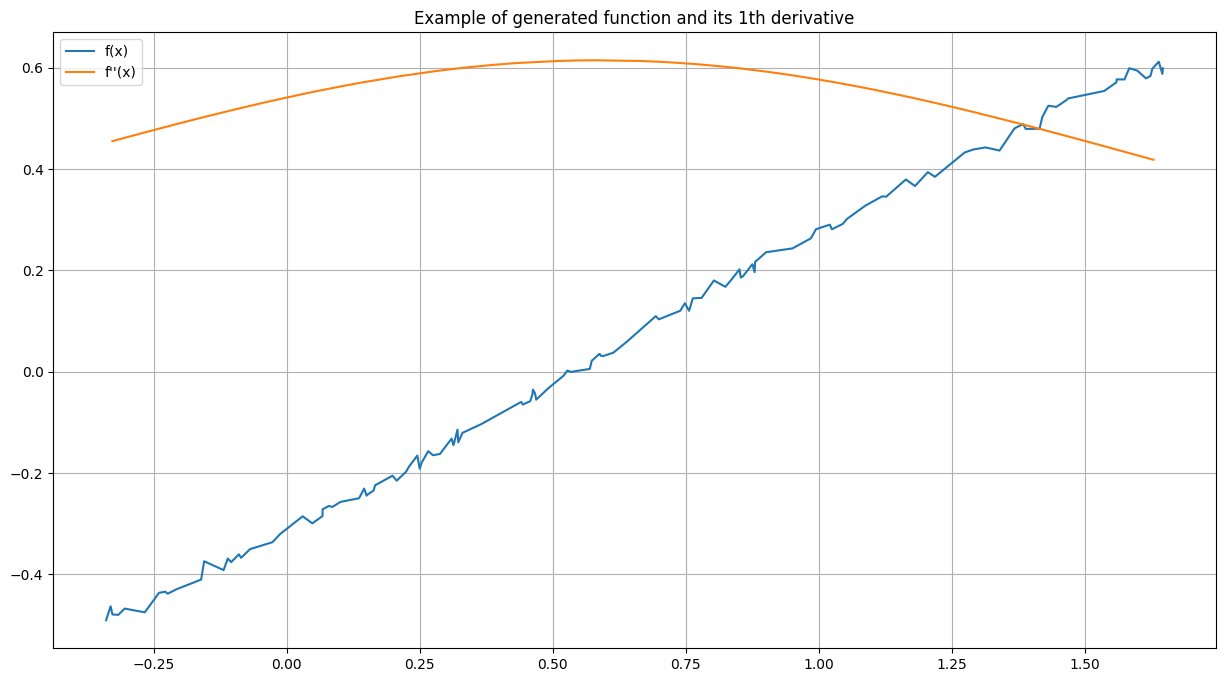

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(i_p, f_e, label="f(x)")
plt.plot(o_p, ddf_e, label="f''(x)")
plt.grid()
plt.legend()
plt.title(f"Example of generated function and its {n}th derivative")
plt.show()

We define the total size of the dataset, and the resolution of the functions sampling. We noise the functions evaluations.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'mps'

In [11]:
def generate_dataset(total_size, length, input_num_points, output_num_points, noise, max_n, verbose=False):
    t = range(total_size)
    if verbose:
        print("Generating", total_size, "samples")
        t = tqdm(t)
    x = se.Symbol('x')
    results = Parallel(n_jobs=-1)(delayed(generate_sample)(x, input_num_points, output_num_points, length, noise, max_n) for _ in t)

    functions, derivatives, input_points, output_points, functions_eval, derivatives_eval, n = zip(*results)

    X = np.array(list(zip(functions_eval, input_points)))
    Y = np.array(list(zip(derivatives_eval, output_points)))

    train_size = int(X.shape[0]*0.5)
    val_size = int(X.shape[0]*0.25)
    test_size = X.shape[0] - train_size - val_size
    
    x_train, y_train, n_train = torch.tensor(X[:train_size], dtype=torch.float32).to(device), torch.tensor(Y[:train_size], dtype=torch.float32).to(device), torch.tensor(n[:train_size], dtype=torch.float32).to(device)
    x_val, y_val, n_val = torch.tensor(X[train_size:train_size+val_size], dtype=torch.float32).to(device), torch.tensor(Y[train_size:train_size+val_size], dtype=torch.float32).to(device), torch.tensor(n[train_size:train_size+val_size], dtype=torch.float32).to(device)
    x_test, y_test, n_test = torch.tensor(X[train_size+val_size:], dtype=torch.float32).to(device), torch.tensor(Y[train_size+val_size:], dtype=torch.float32).to(device), torch.tensor(n[train_size+val_size:], dtype=torch.float32).to(device)
    maxi_0 = x_train[:, 0].max()
    mini_0 = x_train[:, 0].min()
    maxi_1 = x_train[:, 1].max()
    mini_1 = x_train[:, 1].min()
    
    x_train[:, 0] = (x_train[:, 0]-mini_0)/(maxi_0-mini_0)
    x_train[:, 1] = (x_train[:, 1]-mini_1)/(maxi_1-mini_1)
    
    x_val[:, 0] = (x_val[:, 0]-mini_0)/(maxi_0-mini_0)
    x_val[:, 1] = (x_val[:, 1]-mini_1)/(maxi_1-mini_1)
    
    x_test[:, 0] = (x_test[:, 0]-mini_0)/(maxi_0-mini_0)
    x_test[:, 1] = (x_test[:, 1]-mini_1)/(maxi_1-mini_1)
    
    maxi_0_y = y_train[:, 0].max()
    mini_0_y = y_train[:, 0].min()
    maxi_1_y = y_train[:, 1].max()
    mini_1_y = y_train[:, 1].min()
    
    y_train[:, 0] = (y_train[:, 0]-mini_0_y)/(maxi_0_y-mini_0_y)
    y_train[:, 1] = (y_train[:, 1]-mini_1_y)/(maxi_1_y-mini_1_y)
    
    y_val[:, 0] = (y_val[:, 0]-mini_0_y)/(maxi_0_y-mini_0_y)
    y_val[:, 1] = (y_val[:, 1]-mini_1_y)/(maxi_1_y-mini_1_y)
    
    y_test[:, 0] = (y_test[:, 0]-mini_0_y)/(maxi_0_y-mini_0_y)
    y_test[:, 1] = (y_test[:, 1]-mini_1_y)/(maxi_1_y-mini_1_y)
    return x_train, y_train, n_train, x_val, y_val, n_val, x_test, y_test, n_test, maxi_0, mini_0, maxi_1, mini_1, maxi_0_y, mini_0_y, maxi_1_y, mini_1_y

We define the three ML architectures.

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, output_shape)
        
        self.relu = nn.ReLU()

    def forward(self, inputs, query):
        x = self.relu(self.l1(torch.concat([inputs.reshape((inputs.shape[0], -1)), query.reshape((query.shape[0], -1))], axis=1)))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        x = self.l4(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * input_shape//4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_shape)
        
        self.relu = nn.ReLU()

    def forward(self, inputs, query):
        x = self.relu(self.conv1(torch.concat([inputs.reshape((inputs.shape[0], 1, -1)), query.reshape((query.shape[0], 1, -1))], axis=2)))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class NeuralOperator(nn.Module):
    def __init__(self, n_modes_height=64, n_layers=1, hidden_channels=16):
        super(NeuralOperator, self).__init__()
        self.fc = neuralop.models.FNO1d(n_modes_height=n_modes_height, n_layers=n_layers, in_channels=3, out_channels=1, hidden_channels=hidden_channels)

    def forward(self, inputs, query):
        inputs = inputs.view(inputs.size(0), -1, query.size(-1))
        return self.fc(torch.concat([inputs, query.unsqueeze(1)], 1)).squeeze(1)

In [95]:
n_epochs, total_size, length, input_num_points, output_num_points, noise, max_n = 64, int(2**14), 2, 64, 64, 0.01, 9

In [14]:
torch.manual_seed(42)
neural_network = NeuralNetwork(input_num_points*2+output_num_points, output_num_points).to(device)
print("Neural Network:", np.sum([len(i) for i in neural_network.parameters()]), "parameters")

Neural Network: 1920 parameters


In [15]:
torch.manual_seed(42)
cnn = CNN(input_num_points*2+output_num_points, output_num_points).to(device)
print("Convolutional Neural Network:", np.sum([len(i) for i in cnn.parameters()]), "parameters")

Convolutional Neural Network: 1888 parameters


In [16]:
torch.manual_seed(42)
neural_operator = NeuralOperator(128, 4, 64).to(device)
print("Neural Operator:", np.sum([len(i) for i in neural_operator.parameters()]), "parameters")

Neural Operator: 1670 parameters


In [96]:
def train(model, x_train, y_train, n_train, x_val, y_val, n_val, n_epochs):
    best_model = deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    val_losses = []
    best_loss = np.inf
    for epoch in (pbar := tqdm(range(n_epochs))):
        model.train()
        for b in range(x_train.shape[0]):
            optimizer.zero_grad()
            predictions = model(x_train[b:b+1], y_train[b:b+1, 1])
            for _ in range(int(n_train[b].item())-1):
                predictions = model(torch.concatenate([predictions, y_train[b:b+1, 1]], axis=1), y_train[b:b+1, 1])
            loss = criterion(predictions, y_train[b:b+1, 0])
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for b in range(x_val.shape[0]):
                predictions = model(x_val[b:b+1], y_val[b:b+1, 1])
                for _ in range(int(n_val[b].item())-1):
                    predictions = model(torch.concatenate([predictions, y_val[b:b+1, 1]], axis=1), y_val[b:b+1, 1])
                val_loss += criterion(predictions, y_val[b:b+1, 0]).item()
        val_losses.append(val_loss/x_val.shape[0])
        scheduler.step(val_losses[-1])
        pbar.set_description(f"Loss: {val_losses[-1]:.9f}")
        if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            best_model = deepcopy(model)
    return best_model, val_losses

In [97]:
x_train, y_train, n_train, x_val, y_val, n_val, x_test, y_test, n_test, maxi_0, mini_0, maxi_1, mini_1, maxi_0_y, mini_0_y, maxi_1_y, mini_1_y = generate_dataset(total_size, length, input_num_points, output_num_points, noise, max_n, verbose=True)

Generating 16384 samples


  0%|          | 0/16384 [00:00<?, ?it/s]

In [19]:
best_neural_network, losses_neural_network = train(neural_network, x_train, y_train, n_train, x_val, y_val, n_val, n_epochs)

  0%|          | 0/64 [00:00<?, ?it/s]

In [20]:
best_cnn, losses_cnn = train(cnn, x_train, y_train, n_train, x_val, y_val, n_val, n_epochs)

  0%|          | 0/64 [00:00<?, ?it/s]

In [21]:
best_neural_operator, losses_neural_operator = train(neural_operator, x_train, y_train, n_train, x_val, y_val, n_val, n_epochs)

  0%|          | 0/64 [00:00<?, ?it/s]

In [98]:
y_hat_nn = []
y_hat_cnn = []
y_hat_no = []
with torch.no_grad():
    for b in tqdm(range(x_test.shape[0])):
        predictions_nn = best_neural_network(x_test[b:b+1], y_test[b:b+1, 1])
        predictions_cnn = best_cnn(x_test[b:b+1], y_test[b:b+1, 1])
        predictions_no = best_neural_operator(x_test[b:b+1], y_test[b:b+1, 1])
        for _ in range(int(n_test[b].item())-1):
            predictions_nn = best_neural_network(torch.concatenate([predictions_nn, y_test[b:b+1, 1]], axis=1), y_test[b:b+1, 1])
            predictions_cnn = best_cnn(torch.concatenate([predictions_cnn, y_test[b:b+1, 1]], axis=1), y_test[b:b+1, 1])
            predictions_no = best_neural_operator(torch.concatenate([predictions_no, y_test[b:b+1, 1]], axis=1), y_test[b:b+1, 1])
        y_hat_nn.append(predictions_nn.to('cpu'))
        y_hat_cnn.append(predictions_cnn.to('cpu'))
        y_hat_no.append(predictions_no.to('cpu'))
y_hat_nn = np.array(y_hat_nn)
y_hat_cnn = np.array(y_hat_cnn)
y_hat_no = np.array(y_hat_no)

  0%|          | 0/4096 [00:00<?, ?it/s]

In [99]:
errors = {i: {"NN": [], "CNN": [], "NO": [], "CD": [], "SI": []} for i in range(1, max_n)}
averages = {}

y_hat_cd = n_th_diff_central(((x_test[:, 0]*(maxi_0-mini_0))+mini_0).to('cpu'), ((x_test[:, 1]*(maxi_1-mini_1))+mini_1).to('cpu'), y_test[:, 1].to('cpu'), n_test)
y_hat_cd = (y_hat_cd-mini_0_y.item())/(maxi_0_y.item()-mini_0_y.item())

y_hat_si = n_th_diff_interpolate(((x_test[:, 0]*(maxi_0-mini_0))+mini_0).to('cpu'), ((x_test[:, 1]*(maxi_1-mini_1))+mini_1).to('cpu'), y_test[:, 1].to('cpu'), n_test)
y_hat_si = [(y_hat_si[i]-mini_0_y.item())/(maxi_0_y.item()-mini_0_y.item()) for i in range(len(y_hat_si))]

r = 0
n_samples = x_test.shape[0]
for j in range(n_samples):
    i = r + j
    errors[int(n_test[j].item())]["NN"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_nn[i]))
    errors[int(n_test[j].item())]["CNN"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_cnn[i]))
    errors[int(n_test[j].item())]["NO"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_no[i]))
    errors[int(n_test[j].item())]["CD"].append(error(y_test[i, 0].to("cpu").numpy(), y_hat_cd[i]))
    errors[int(n_test[j].item())]["SI"].append(error(y_test[i, 0, :-int(n_test[j].item())].to("cpu").numpy(), y_hat_si[i]))
for n in range(1, max_n):
    averages[n] = {i: np.mean(errors[n][i]) for i in errors[n]}
    print(f"n = {n}")
    for i in sorted(averages[n], key=lambda x: averages[n][x]):
        print(f"\t{i}:\t{averages[n][i]:.7f}")

n = 1
	NO:	0.0619248
	CNN:	0.0786396
	SI:	0.1030181
	NN:	0.1160963
	CD:	0.2311322
n = 2
	NO:	0.0532571
	CNN:	0.0634754
	SI:	0.1112025
	NN:	0.1232590
	CD:	5.1179432
n = 3
	NO:	0.0582588
	CNN:	0.0594761
	NN:	0.1182585
	SI:	0.1197437
	CD:	23139.0739366
n = 4
	NO:	0.0611305
	CNN:	0.0627220
	NN:	0.0875291
	SI:	0.0898354
	CD:	1643093.1358113
n = 5
	NN:	0.0579390
	SI:	0.0579876
	NO:	0.0709655
	CNN:	0.0717129
	CD:	51856460.2323933
n = 6
	SI:	0.0456428
	NN:	0.0467136
	CNN:	0.0926589
	NO:	0.0983589
	CD:	2471214242.3876257
n = 7
	NN:	0.0493656
	SI:	0.0496940
	NO:	0.1272558
	CNN:	0.1280695
	CD:	8556152795530.5000000
n = 8
	NN:	0.0428525
	SI:	0.0481736
	NO:	0.1571955
	CNN:	0.1675518
	CD:	89906330817890160.0000000


In [ ]:
reerereeeeeeeeeee

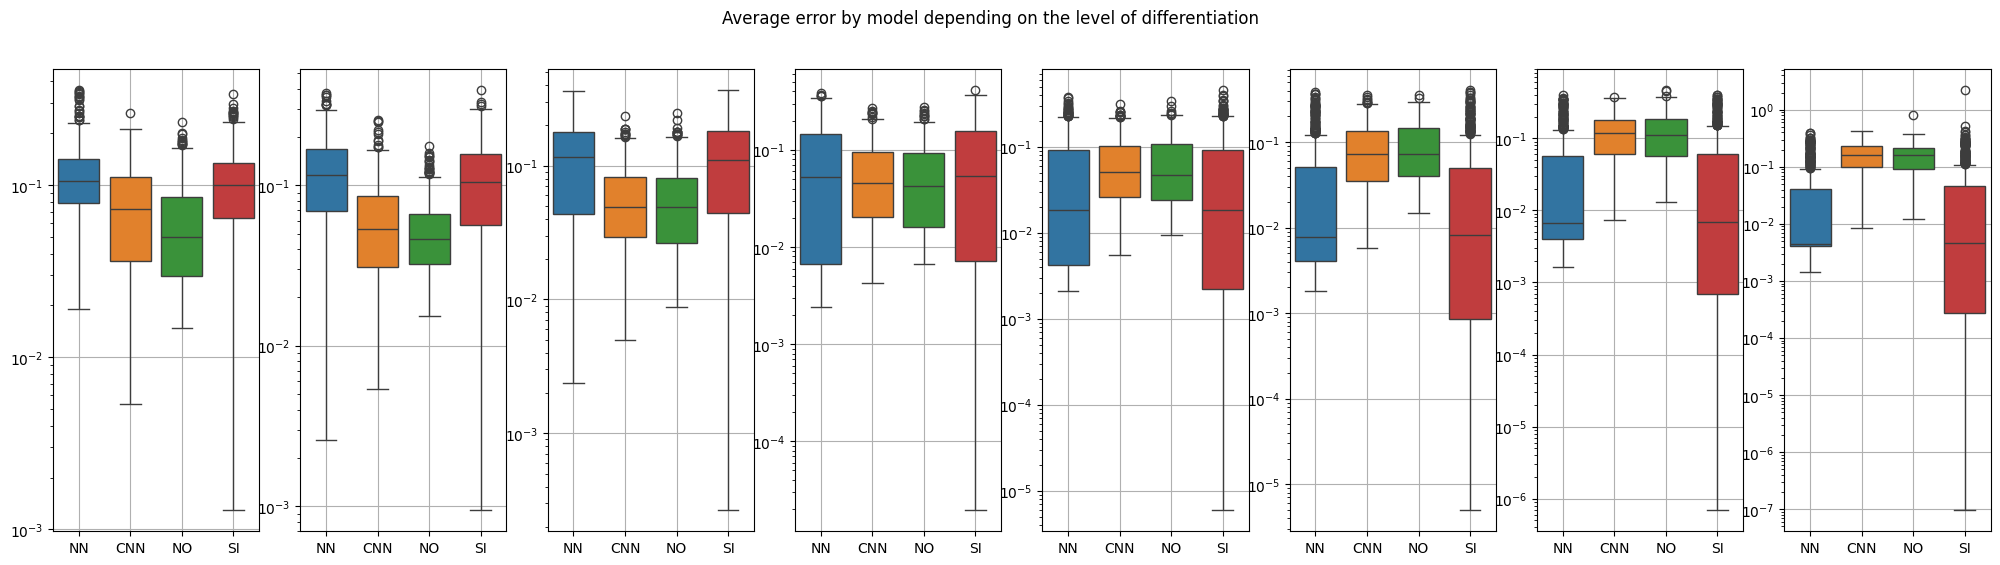

In [100]:
fig, ax = plt.subplots(1, max_n-1, figsize=(25, 6))
for i in errors:
    sns.boxplot(pd.DataFrame(errors[i]).drop("CD", axis=1), ax=ax[i-1])
    ax[i-1].grid()
    ax[i-1].set_yscale('log')
plt.suptitle("Average error by model depending on the level of differentiation")
plt.show()

## Conclusion
We see that the composition of the ML architectures with itself yields quite constant results.

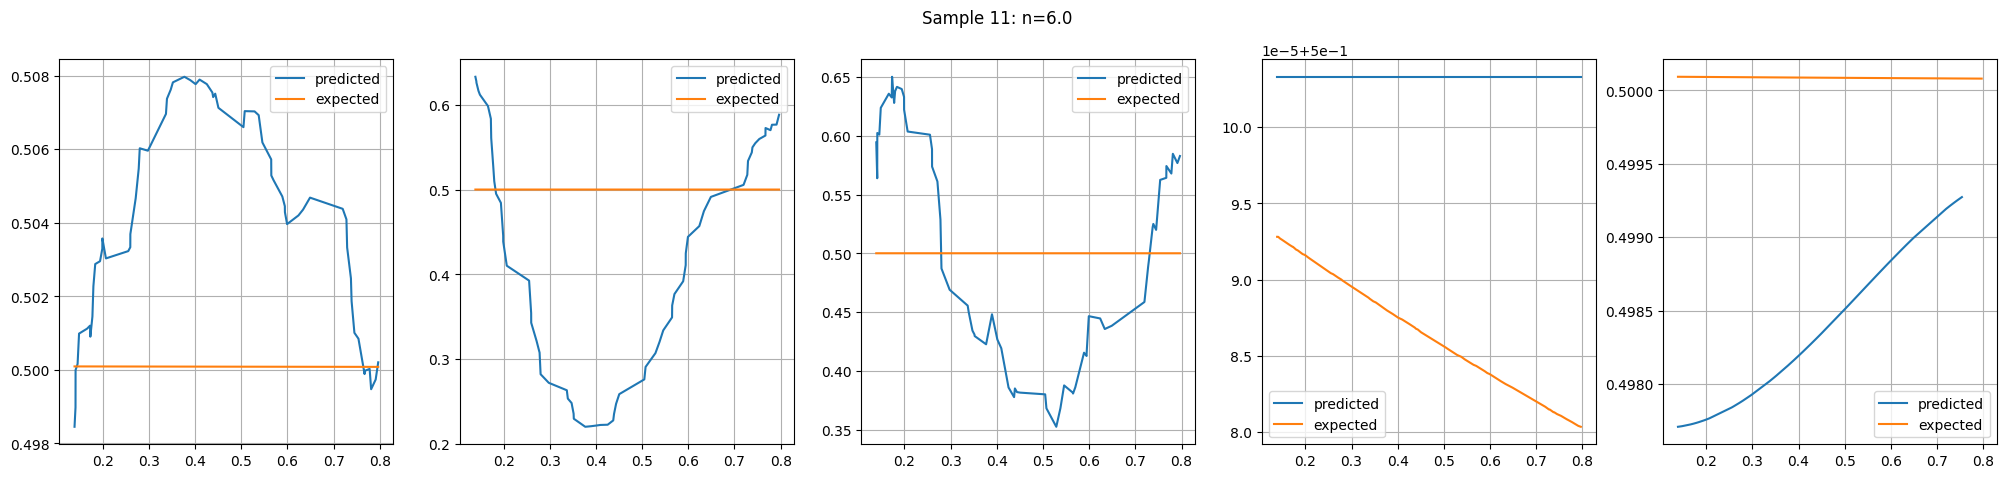

In [139]:
idx = 11
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax[0].plot(y_test[idx, 1].to("cpu"), y_hat_nn[idx, 0], label="predicted")
ax[1].plot(y_test[idx, 1].to("cpu"), y_hat_cnn[idx, 0], label="predicted")
ax[2].plot(y_test[idx, 1].to("cpu"), y_hat_no[idx, 0], label="predicted")
ax[3].plot(y_test[idx, 1].to("cpu"), y_hat_cd[idx, 0], label="predicted")
ax[4].plot(y_test[idx, 1, :-int(n_test[idx])].to("cpu"), y_hat_si[idx][0], label="predicted")
for i in range(5):
    ax[i].plot(y_test[idx, 1].to("cpu"), y_test[idx, 0].to("cpu"), label="expected")
    ax[i].grid()
    ax[i].legend()
plt.suptitle(f"Sample {idx}: n={n_test[idx]}")
plt.show()